In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr

from skdownscale.pointwise_models import BcsdPrecipitation, BcsdTemperature

In [2]:
# utilities for plotting cdfs
def plot_cdf(ax=None, **kwargs):
    if ax:
        plt.sca(ax)
    else:
        ax = plt.gca()

    for label, X in kwargs.items():
        vals = np.sort(X, axis=0)
        pp = scipy.stats.mstats.plotting_positions(vals)
        ax.plot(pp, vals, label=label)
    ax.legend()
    return ax


def plot_cdf_by_month(ax=None, **kwargs):
    fig, axes = plt.subplots(4, 3, sharex=True, sharey=False, figsize=(12, 8))

    for label, X in kwargs.items():
        for month, ax in zip(range(1, 13), axes.flat):
            vals = np.sort(X[X.index.month == month], axis=0)
            pp = scipy.stats.mstats.plotting_positions(vals)
            ax.plot(pp, vals, label=label)
            ax.set_title(month)
    ax.legend()
    return ax

In [3]:
# open a small dataset for training
training_time_slice = slice('1980', '2001')
data = xr.open_datatree(
    's3://carbonplan/share/scikit-downscale/test-data.zarr',
    engine='zarr',
    chunks={},
    storage_options={'anon': True, 'endpoint_url': 'https://rice1.osn.mghpcc.org'},
)
training = data['training'].to_dataset().sel(time=training_time_slice)
training

<xarray.Dataset> Size: 2MB
Dimensions:      (point: 5, time: 8036)
Coordinates:
  * time         (time) datetime64[ns] 64kB 1980-01-01T11:30:00 ... 2001-12-3...
    lat          (point) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
    lon          (point) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: point
Data variables: (12/15)
    DIV          (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PREC_ACC_C   (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PREC_ACC_NC  (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PREC_TOT     (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PSFC         (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    QVAPOR       (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    ...           ...
    T2min        (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    T_MEAN       (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    T_RANGE      (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    U            (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    V            (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    W            (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
Attributes:
    NCO:                        "4.5.5"
    history:                    Wed Mar  1 13:48:35 2017: ncatted -a calendar...
    history_of_appended_files:  Wed Feb  8 14:15:52 2017: Appended file wrf_d...
    nco_openmp_thread_number:   1

In [4]:
# open a small dataset of observations (targets)
targets = data['targets'].to_dataset().sel(time=training_time_slice)
targets

<xarray.Dataset> Size: 707kB
Dimensions:  (time: 8036, point: 5)
Coordinates:
  * time     (time) datetime64[ns] 64kB 1980-01-01 1980-01-02 ... 2001-12-31
    lat      (point) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    lon      (point) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: point
Data variables:
    Prec     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
    Tmax     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
    Tmin     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
    wind     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.6.4 (http://c...
    CDO:                       Climate Data Operators version 1.6.4 (http://c...
    Conventions:               CF-1.4
    NCO:                       4.4.5
    history:                   Fri Oct 10 17:54:37 2014: cdo ifthenelse /Volu...
    nco_openmp_thread_number:  1

In [5]:
# extract 1 point of training data for precipitation and temperature
X_temp = training.isel(point=0).to_dataframe()[['T2max']].resample('MS').mean() - 273.13
X_pcp = training.isel(point=0).to_dataframe()[['PREC_TOT']].resample('MS').sum() * 24
display(X_temp.head(), X_pcp.head())

,T2max
time,
1980-01-01,3.311554
1980-02-01,9.825073
1980-03-01,8.480286
1980-04-01,17.126617
1980-05-01,19.055573


,PREC_TOT
time,
1980-01-01,93.716293
1980-02-01,128.091492
1980-03-01,136.653229
1980-04-01,70.510910
1980-05-01,103.933807


In [6]:
# extract 1 point of target data for precipitation and temperature
y_temp = targets.isel(point=0).to_dataframe()[['Tmax']].resample('MS').mean()
y_pcp = targets.isel(point=0).to_dataframe()[['Prec']].resample('MS').sum()
display(y_temp.head(), y_pcp.head())

,Tmax
time,
1980-01-01,3.545161
1980-02-01,8.900001
1980-03-01,9.139677
1980-04-01,16.180000
1980-05-01,16.735161


,Prec
time,
1980-01-01,149.882751
1980-02-01,177.640610
1980-03-01,187.000565
1980-04-01,124.414742
1980-05-01,89.521523


/Users/andersy005/devel/pangeo-data/scikit-downscale/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: xlabel='time'>

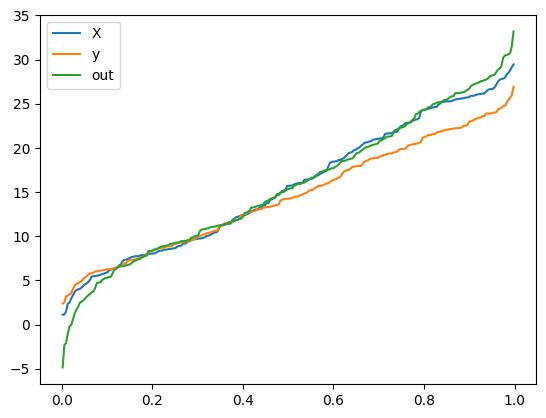

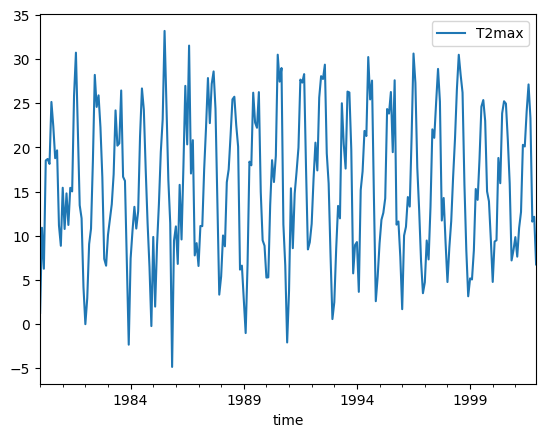

In [7]:
# Fit/predict the BCSD Temperature model
bcsd_temp = BcsdTemperature()
bcsd_temp.fit(X_temp, y_temp)
out = bcsd_temp.predict(X_temp) + X_temp
plot_cdf(X=X_temp, y=y_temp, out=out)
out.plot()

<Axes: title={'center': '12'}>

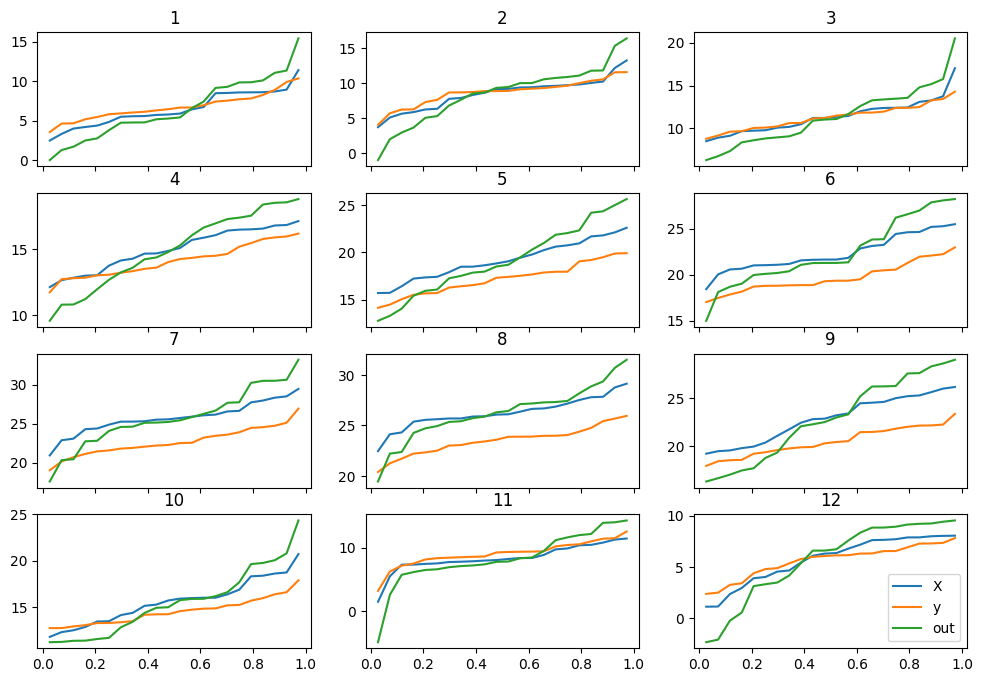

In [8]:
plot_cdf_by_month(X=X_temp, y=y_temp, out=out)

/Users/andersy005/devel/pangeo-data/scikit-downscale/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: >

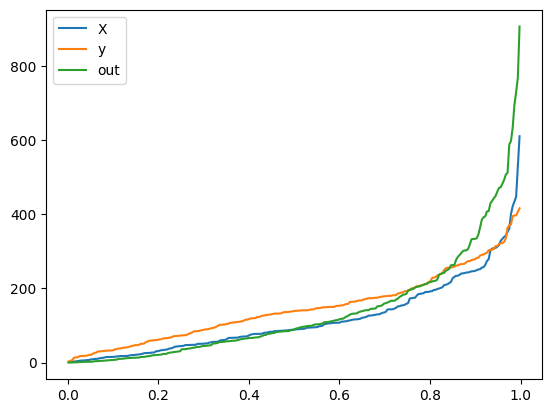

In [9]:
# Fit/predict the BCSD Precipitation model
bcsd_pcp = BcsdPrecipitation()
bcsd_pcp.fit(X_pcp, y_pcp)
out = bcsd_pcp.predict(X_pcp) * X_pcp
plot_cdf(X=X_pcp, y=y_pcp, out=out)

<Axes: title={'center': '12'}>

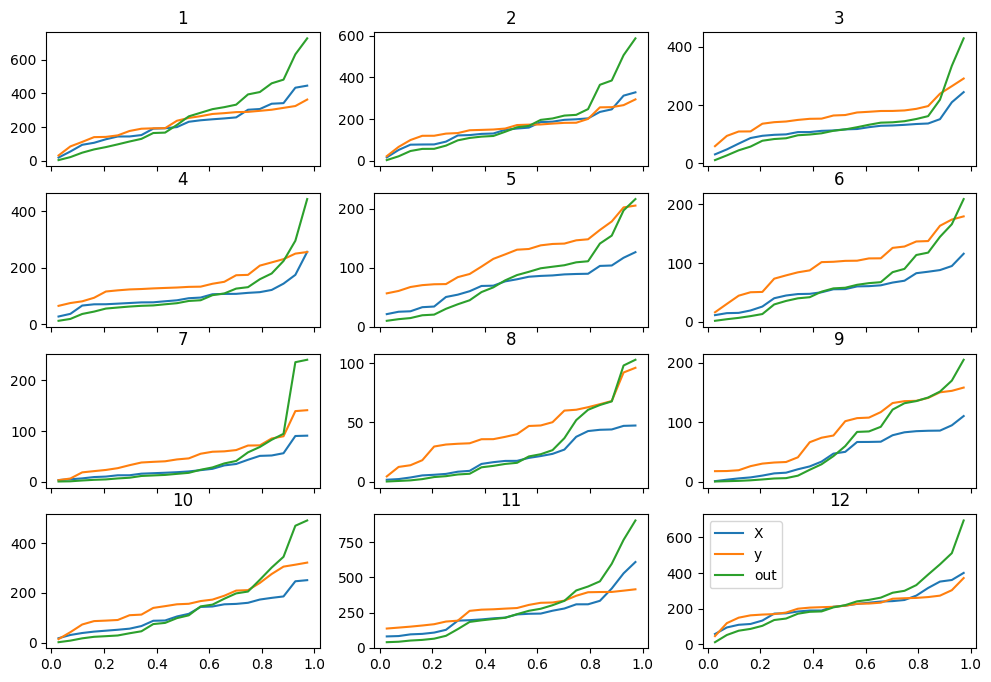

In [10]:
plot_cdf_by_month(X=X_pcp, y=y_pcp, out=out)